# Graph Neural Network for Multi-Asset Market Modeling — Variant C 📈

This notebook implements a GNN + LSTM model for predicting the next-step direction of Asset A using multi-asset time series, incorporating **learnable attention** over a set of precomputed correlation windows.

### Features
- Candidate correlation windows: **30min, 1h, 2h, 4h**
- **NaN-safe** normalization and correlation calculation.
- **Multi-window attention** (softmax-weighted combination) for dynamic correlation weighting.
- Monitoring attention weights per epoch for **interpretability**.
- Synthetic dataset $T \approx 3000$.

In [49]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Research-grade GNN-LSTM pipeline for multi-asset market modeling.
Predicts direction of price for Asset ETH using multi-window attention over correlations.

Structure:
1) Synthetic data generation (3k rows, 5m intervals)
2) Preprocessing, cleaning, winsorization, normalization
3) Rolling correlations with multiple windows (5 windows)
4) Dataset + DataLoader + collate_fn
5) GNN (GCN-style) + LSTM temporal aggregator + classifier
6) Train/Val/Test split 50-20-30
7) Training loop with accuracy, loss tracking
8) Monitoring attention + avg adjacency
9) Visualization for train and for test
"""
import numpy as np
import pandas as pd
from pathlib import Path

In [50]:

# ============================================================
# 1. Load data
# ============================================================


def load_asset(asset):
    freq = '5min'
    DATA_DIR = Path('../dataset')
    path = DATA_DIR / f"{asset}_{freq}.csv"

    df = pd.read_csv(path)
    df['timestamp'] = pd.to_datetime(df["system_time"])
    df['timestamp'] = df['timestamp'].dt.round('min')
    df = df.sort_values('timestamp').set_index('timestamp')
    return df[['midpoint','bids_notional_0', 'asks_notional_0', 'spread', 'buys', 'sells']]  
    
df_ADA = load_asset("ADA").rename(columns={'midpoint': 'ADA', 'buys': 'buys_ADA', 'sells': 'sells_ADA', 'bids_notional_0': 'bids_vol_ADA', 'asks_notional_0': 'asks_vol_ADA', 'spread': 'spread_ADA', })
df_BTC = load_asset("BTC").rename(columns={'midpoint': 'BTC', 'buys': 'buys_BTC', 'sells': 'sells_BTC', 'bids_notional_0': 'bids_vol_BTC', 'asks_notional_0': 'asks_vol_BTC', 'spread': 'spread_BTC', })
df_ETH = load_asset("ETH").rename(columns={'midpoint': 'ETH', 'buys': 'buys_ETH', 'sells': 'sells_ETH', 'bids_notional_0': 'bids_vol_ETH', 'asks_notional_0': 'asks_vol_ETH', 'spread': 'spread_ETH', })
df = df_ADA.join(df_BTC).join(df_ETH)

df.reset_index(inplace=True)

T = len(df)

# log returns & target
df["lr_ADA"] = np.log(df["ADA"]).diff().fillna(0)
df["lr_BTC"] = np.log(df["BTC"]).diff().fillna(0)
df["lr_ETH"] = np.log(df["ETH"]).diff().fillna(0)
df["target"] = (df["ETH"].shift(-1) > df["ETH"]).astype(int) #next-step direction of Asset ETH --- 50%
#df["target"] = (df["lr_ETH"].shift(-6).abs() > 0.003).astype(int)  # significant move in next 30min --- 70%-80%
#df["target"] = ((df["lr_ETH"].shift(-6) > 0) & (df["lr_ETH"].shift(-6).abs() > 0.001)).astype(int)  # direction of significant move in next 30min --- 60%-70%
#df["target"] = (df["ETH"].shift(-6) > df["ETH"]).astype(int)    # direction in next 30min --- 50%

#df["fwd_lr_12"] = df["lr_ETH"].rolling(12).sum().shift(-12)
#df["target"] = (df["fwd_lr_12"] > 0).astype(int) # cumulative log return of 1h move --- 50%-54%

#df["target"] = (((df["lr_ETH"].shift(-6) > 0)-0.5)*2 * (df["lr_ETH"].shift(-6).abs() > 0.002)).astype(int)+1  # direction of significant move in next 30min --- 62% against 79% baseline


In [51]:
COLUMNS = ["ADA",
            "buys_ADA", 
            "sells_ADA",
            "bids_vol_ADA",
            "asks_vol_ADA",
            "spread_ADA", 
            "lr_ADA", 
            # ---
            "BTC",
            "buys_BTC", 
            "sells_BTC",
            "bids_vol_BTC",
            "asks_vol_BTC",
            "spread_BTC",
            "lr_BTC",
            # ---
            "ETH",
            "buys_ETH", 
            "sells_ETH",
            "bids_vol_ETH",
            "asks_vol_ETH",
            "spread_ETH",
            "lr_ETH"]


df.target.value_counts(normalize=True)


target
1    0.509356
0    0.490644
Name: proportion, dtype: float64

In [52]:

# ============================================================
# 3. Multi-window correlations
# ============================================================

candidate_windows = [6, 12, 24, 48, 96]   # 30m, 1h, 2h, 4h, 8h
n_w = len(candidate_windows)

edges = [("ADA","BTC"), ("ADA","ETH"), ("ETH","BTC")]
n_edges = len(edges)

corr_array = np.zeros((T, n_edges, n_w), dtype=np.float32)

for wi, w in enumerate(candidate_windows):
    r_ADA_BTC = df["lr_ADA"].rolling(w, min_periods=1).corr(df["lr_BTC"])
    r_ADA_ETH = df["lr_ADA"].rolling(w, min_periods=1).corr(df["lr_ETH"])
    r_ETH_BTC = df["lr_ETH"].rolling(w, min_periods=1).corr(df["lr_BTC"])

    corr_array[:,0,wi] = np.nan_to_num(r_ADA_BTC)
    corr_array[:,1,wi] = np.nan_to_num(r_ADA_ETH)
    corr_array[:,2,wi] = np.nan_to_num(r_ETH_BTC)

print("corr_array shape:", corr_array.shape)


corr_array shape: (3367, 3, 5)


In [53]:
#df.dtypes

## Step 0

In [54]:
# ЛОГИЧЕСКИЙ БЛОК: imports + reproducibility + config
# ИСПОЛНЕНИЕ БЛОКА:

import os, math, random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix

import matplotlib.pyplot as plt

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

CFG = {
    "lookback": 48,          # 4 часа при 5m
    "horizon": 1,            # твой target уже next-step (shift -1)
    "batch_size": 128,
    "epochs": 30,
    "lr": 2e-4,
    "weight_decay": 1e-3,
    "grad_clip": 1.0,
    "dropout": 0.15,
    "hidden": 64,            # размер node-эмбеддинга
    "gnn_layers": 2,
    "lstm_hidden": 64,
    "lstm_layers": 1,
    "label_smoothing": 0.02,
    "max_abs_feat": 10.0,    # пост-клип после скейлинга
    "use_amp": True,         # mixed precision если cuda
}

ASSETS = ["ADA", "BTC", "ETH"]
ASSET2IDX = {a:i for i,a in enumerate(ASSETS)}
TARGET_ASSET = "ETH"
TARGET_NODE = ASSET2IDX[TARGET_ASSET]

# фиксированный список ребер как у тебя (E=3)
EDGES = [("ADA","BTC"), ("ADA","ETH"), ("ETH","BTC")]
EDGE_INDEX = torch.tensor([[ASSET2IDX[s], ASSET2IDX[t]] for (s,t) in EDGES], dtype=torch.long)  # [E,2]
print("EDGE_INDEX:", EDGE_INDEX.tolist())


DEVICE: cpu
EDGE_INDEX: [[0, 1], [0, 2], [2, 1]]


## 1. Feature engineering: node-features и edge-features

In [55]:
# ЛОГИЧЕСКИЙ БЛОК: triple-barrier labels + exit returns/time (ETH)
# ИСПОЛНЕНИЕ БЛОКА:

import numpy as np
import pandas as pd

def triple_barrier_labels_from_lr(
    lr: pd.Series,
    horizon: int = 12,            # 12*5m = 1h
    vol_window: int = 96,         # 8h
    pt_mult: float = 1.5,         # take profit multiplier
    sl_mult: float = 1.5,         # stop loss multiplier
    min_barrier: float = 0.0006,  # floor (важно при около-нулевом vol)
    max_barrier: float = 0.02     # cap
):
    """
    Возвращает:
      y_tb: int {0=down, 1=flat/no-trade, 2=up}
      exit_ret: log-return до выхода (tp/sl/timeout)
      exit_t: индекс выхода (t+dt)
      thr: барьер (log-return) на каждом t
    Важно: threshold считается на основе прошлой волы (shift(1)), без leakage.
    """
    lr = lr.astype(float).copy()
    T = len(lr)

    # rolling vol from PAST only
    vol = lr.rolling(vol_window, min_periods=max(10, vol_window//10)).std().shift(1)
    # scale barrier with sqrt(horizon) (приближение)
    thr = (vol * np.sqrt(horizon)).clip(lower=min_barrier, upper=max_barrier)

    y = np.ones(T, dtype=np.int64)          # default flat
    exit_ret = np.zeros(T, dtype=np.float32)
    exit_t = np.arange(T, dtype=np.int64)

    lr_np = lr.fillna(0.0).to_numpy(dtype=np.float64)
    thr_np = thr.fillna(min_barrier).to_numpy(dtype=np.float64)

    for t in range(T - horizon - 1):
        up = pt_mult * thr_np[t]
        dn = -sl_mult * thr_np[t]

        cum = 0.0
        hit = 1
        et = t + horizon
        er = 0.0

        for dt in range(1, horizon + 1):
            cum += lr_np[t + dt]
            # first touch logic
            if cum >= up:
                hit = 2
                et = t + dt
                er = cum
                break
            if cum <= dn:
                hit = 0
                et = t + dt
                er = cum
                break

        if hit == 1:
            # timeout: use horizon cumret
            er = float(np.sum(lr_np[t+1:t+horizon+1]))
            et = t + horizon

        y[t] = hit
        exit_ret[t] = er
        exit_t[t] = et

    # tail defaults already set (flat, 0 ret)
    return y, exit_ret, exit_t, thr_np

# === build TB labels for ETH ===
y_tb, exit_ret, exit_t, thr = triple_barrier_labels_from_lr(
    df["lr_ETH"],
    horizon=12, vol_window=48,
    pt_mult=1.5, sl_mult=1.5,
    min_barrier=0.0006, max_barrier=0.004
)

print("TB label distribution (0=down,1=flat,2=up):", np.bincount(y_tb, minlength=3))
print("Example thr stats:", np.min(thr), np.median(thr), np.max(thr))


TB label distribution (0=down,1=flat,2=up): [1017 1245 1105]
Example thr stats: 0.0006 0.004 0.004


In [56]:
# ЛОГИЧЕСКИЙ БЛОК: build node features (T,N,F) + edge features (T,E,W) + target
# ИСПОЛНЕНИЕ БЛОКА:

assert "target" in df.columns, "df должен содержать 'target'"
assert isinstance(corr_array, np.ndarray) and corr_array.ndim == 3, "corr_array должен быть (T,E,W)"
T = len(df)
E = corr_array.shape[1]
W = corr_array.shape[2]
assert E == len(EDGES), "corr_array E должно совпадать с EDGES"
print("T,E,W:", T, E, W)

EPS = 1e-6

def safe_log1p(x):
    return np.log1p(np.maximum(x, 0.0))

def build_node_tensor(df: pd.DataFrame):
    feats = []
    feat_names = []
    for a in ASSETS:
        # обязательные колонки по твоей схеме
        lr = df[f"lr_{a}"].values.astype(np.float32)
        spread = df[f"spread_{a}"].values.astype(np.float32)

        bids = df[f"bids_vol_{a}"].values.astype(np.float32)
        asks = df[f"asks_vol_{a}"].values.astype(np.float32)
        buys = df[f"buys_{a}"].values.astype(np.float32)
        sells = df[f"sells_{a}"].values.astype(np.float32)

        # устойчивые преобразования
        log_bids = safe_log1p(bids).astype(np.float32)
        log_asks = safe_log1p(asks).astype(np.float32)
        log_buys = safe_log1p(buys).astype(np.float32)
        log_sells = safe_log1p(sells).astype(np.float32)

        ofi = (buys - sells) / (buys + sells + EPS)
        di  = (bids - asks)  / (bids + asks + EPS)
        ofi = ofi.astype(np.float32)
        di  = di.astype(np.float32)

        # (T,F_a)
        Xa = np.stack([lr, spread, log_bids, log_asks, log_buys, log_sells, ofi, di], axis=1)
        feats.append(Xa)
        if not feat_names:
            feat_names = ["lr", "spread", "log_bids", "log_asks", "log_buys", "log_sells", "ofi", "di"]

    # (T,N,F)
    X = np.stack(feats, axis=1).astype(np.float32)
    return X, feat_names

X_node_raw, node_feat_names = build_node_tensor(df)               # (T,N,F) raw
edge_feat_clean = np.nan_to_num(corr_array.astype(np.float32), nan=0.0, posinf=0.0, neginf=0.0)

T = len(df)
L = CFG["lookback"]
TB_H = 12

t_min = L - 1
t_max = T - TB_H - 2
sample_t = np.arange(t_min, t_max + 1)
n_samples = len(sample_t)

print("X_node_raw:", X_node_raw.shape, "edge:", edge_feat_clean.shape)
print("n_samples:", n_samples, "t range:", sample_t[0], sample_t[-1])



T,E,W: 3367 3 5
X_node_raw: (3367, 3, 8) edge: (3367, 3, 5)
n_samples: 3307 t range: 47 3353


## 2. Walk-forward splits (expanding train, fixed val/test windows)

In [57]:
# ЛОГИЧЕСКИЙ БЛОК: walk-forward split generator over sample_t indices
# ИСПОЛНЕНИЕ БЛОКА:

def make_walk_forward_splits(n_samples, 
                             train_min_frac=0.50, 
                             val_frac=0.10, 
                             test_frac=0.10,
                             step_frac=0.10):
    """
    Expanding train, rolling val/test.
    Returns list of (idx_train, idx_val, idx_test) in sample-index space.
    """
    train_min = int(train_min_frac * n_samples)
    val_size  = int(val_frac * n_samples)
    test_size = int(test_frac * n_samples)
    step_size = int(step_frac * n_samples)

    splits = []
    start = train_min
    while True:
        tr_end = start
        va_end = tr_end + val_size
        te_end = va_end + test_size
        if te_end > n_samples:
            break
        idx_train = np.arange(0, tr_end)
        idx_val   = np.arange(tr_end, va_end)
        idx_test  = np.arange(va_end, te_end)
        splits.append((idx_train, idx_val, idx_test))
        start += step_size
    return splits

# sample_t должен быть рассчитан как в твоём пайплайне (из предыдущего кода):
# t_min = L - 1 ; t_max = T - H - 1 ; sample_t = np.arange(t_min, t_max+1)

walk_splits = make_walk_forward_splits(n_samples=len(sample_t),
                                       train_min_frac=0.50,
                                       val_frac=0.10,
                                       test_frac=0.10,
                                       step_frac=0.10)

print("n_folds:", len(walk_splits))
for k,(a,b,c) in enumerate(walk_splits[:3],1):
    print(k, len(a), len(b), len(c), "sample_t_end(train):", sample_t[a[-1]])


n_folds: 4
1 1653 330 330 sample_t_end(train): 1699
2 1983 330 330 sample_t_end(train): 2029
3 2313 330 330 sample_t_end(train): 2359


## 3. Dataset + collate_fn

In [58]:
# ЛОГИЧЕСКИЙ БЛОК: dataset for TB 3-class (+ exit_ret)
# ИСПОЛНЕНИЕ БЛОКА:

import torch
from torch.utils.data import Dataset, DataLoader

class LobGraphSequenceDatasetTB(Dataset):
    def __init__(self, X_node, E_feat, y_tb, exit_ret, sample_t, indices, lookback):
        self.X_node = X_node
        self.E_feat = E_feat
        self.y_tb = y_tb
        self.exit_ret = exit_ret
        self.sample_t = sample_t
        self.indices = indices
        self.L = lookback

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        sidx = self.indices[i]
        t = self.sample_t[sidx]
        t0 = t - self.L + 1
        x_seq = self.X_node[t0:t+1]         # (L,N,F)
        e_seq = self.E_feat[t0:t+1]         # (L,E,W)
        y = self.y_tb[t]                    # {0,1,2}
        er = self.exit_ret[t]               # realized log-ret to exit
        return (torch.from_numpy(x_seq),
                torch.from_numpy(e_seq),
                torch.tensor(y, dtype=torch.long),
                torch.tensor(er, dtype=torch.float32))

def collate_fn_tb(batch):
    xs, es, ys, ers = zip(*batch)
    x = torch.stack(xs, 0)      # (B,L,N,F)
    e = torch.stack(es, 0)      # (B,L,E,W)
    y = torch.stack(ys, 0)      # (B,)
    er = torch.stack(ers, 0)    # (B,)
    return x, e, y, er

def fit_scale_nodes_train_only(X_node_raw, sample_t, idx_train, max_abs=10.0):
    """
    Fit RobustScaler on all times up to last train sample end time.
    """
    last_train_t = sample_t[idx_train[-1]]
    train_time_mask = np.arange(0, last_train_t + 1)
    X_train_time = X_node_raw[train_time_mask]  # (Ttr,N,F)

    Ttr, N, Fdim = X_train_time.shape
    scaler = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(5.0, 95.0))
    scaler.fit(X_train_time.reshape(-1, Fdim))

    X_scaled = scaler.transform(X_node_raw.reshape(-1, Fdim)).reshape(X_node_raw.shape).astype(np.float32)
    X_scaled = np.clip(X_scaled, -max_abs, max_abs).astype(np.float32)
    X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
    return X_scaled, scaler

def compute_pos_weight_from_samples(y_arr, sample_t, idx_train):
    ytr = y_arr[sample_t[idx_train]]
    pos = int((ytr == 1).sum())
    neg = int((ytr == 0).sum())
    pos = max(pos, 1)
    return float(neg / pos), ytr.mean()

print("Ready dataset+scaling utils.")

print("TB dataset ready.")


Ready dataset+scaling utils.
TB dataset ready.


## 4. GNN слой с edge-conditioned gating (отдельная edge-нейросеть) + LSTM

In [59]:
# ЛОГИЧЕСКИЙ БЛОК: 3-class TB model
# ИСПОЛНЕНИЕ БЛОКА:


class EdgeGatedMP(nn.Module):
    def __init__(self, in_dim, hidden, edge_dim, dropout=0.1):
        super().__init__()
        self.node_proj = nn.Linear(in_dim, hidden)
        self.ln0 = nn.LayerNorm(hidden)

        # edge network: takes [h_src, h_dst, e_attr] -> gate + msg
        self.edge_mlp = nn.Sequential(
            nn.Linear(2*hidden + edge_dim, 2*hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(2*hidden, hidden + 1)  # msg(hidden) + gate(1)
        )

        self.upd = nn.Sequential(
            nn.Linear(2*hidden, 2*hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(2*hidden, hidden)
        )
        self.ln1 = nn.LayerNorm(hidden)
        self.dropout = nn.Dropout(dropout)

    def forward_once(self, x_t, edge_attr_t, edge_index):
        """
        x_t: (B,N,F_in)
        edge_attr_t: (B,E,edge_dim)
        edge_index: (E,2) [src,dst]
        returns: (B,N,H)
        """
        B, N, _ = x_t.shape
        E = edge_index.shape[0]

        h = self.ln0(self.node_proj(x_t))  # (B,N,H)
        h = torch.nan_to_num(h, nan=0.0, posinf=0.0, neginf=0.0)

        agg = torch.zeros((B, N, h.shape[-1]), device=h.device, dtype=h.dtype)

        # E маленькое (3) — можно честный цикл, зато стабильнее и проще
        for e in range(E):
            src = edge_index[e, 0].item()
            dst = edge_index[e, 1].item()
            h_src = h[:, src, :]  # (B,H)
            h_dst = h[:, dst, :]  # (B,H)
            ea    = edge_attr_t[:, e, :]  # (B,edge_dim)

            z = torch.cat([h_src, h_dst, ea], dim=-1)
            out = self.edge_mlp(z)         # (B, H+1)
            msg = out[:, :-1]
            gate = torch.sigmoid(out[:, -1:])  # (B,1)

            msg = msg * gate
            agg[:, dst, :] += msg

        h2 = self.upd(torch.cat([h, agg], dim=-1))
        h2 = self.ln1(h + self.dropout(h2))
        h2 = torch.nan_to_num(h2, nan=0.0, posinf=0.0, neginf=0.0)
        return h2

    def forward(self, x_seq, e_seq, edge_index):
        """
        x_seq: (B,L,N,F_in)
        e_seq: (B,L,E,edge_dim)
        returns node embeddings over time: (B,L,N,H)
        """
        B, L, N, Fin = x_seq.shape
        edge_dim = e_seq.shape[-1]

        h_out = []
        # step-wise MP over time
        for t in range(L):
            h_t = x_seq[:, t, :, :]     # (B,N,Fin)
            ea_t = e_seq[:, t, :, :]    # (B,E,edge_dim)
            ht = self.forward_once(h_t, ea_t, edge_index)
            h_out.append(ht)

        return torch.stack(h_out, dim=1)  # (B,L,N,H)

class GNN_LSTM_TB(nn.Module):
    def __init__(self, node_in, edge_dim, hidden, gnn_layers, lstm_hidden, lstm_layers, dropout=0.1, target_node=2):
        super().__init__()
        self.target_node = target_node

        self.gnns = nn.ModuleList()
        for i in range(gnn_layers):
            in_dim = node_in if i == 0 else hidden
            self.gnns.append(EdgeGatedMP(in_dim=in_dim, hidden=hidden, edge_dim=edge_dim, dropout=dropout))

        self.lstm = nn.LSTM(
            input_size=hidden,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0.0
        )

        self.head = nn.Sequential(
            nn.LayerNorm(lstm_hidden),
            nn.Dropout(dropout),
            nn.Linear(lstm_hidden, lstm_hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(lstm_hidden, 3)  # logits for {down, flat, up}
        )

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x, e, edge_index):
        h = x
        for gnn in self.gnns:
            h = gnn(h, e, edge_index)          # (B,L,N,H)

        h_tgt = h[:, :, self.target_node, :]   # (B,L,H)
        out, _ = self.lstm(h_tgt)              # (B,L,lstm_hidden)
        last = out[:, -1, :]                   # (B,lstm_hidden)
        logits = self.head(last)               # (B,3)
        logits = torch.nan_to_num(logits, nan=0.0, posinf=0.0, neginf=0.0)
        return logits

print("TB model class ready.")


TB model class ready.


## 5. Cost-sensitive метрики: precision@k, hit-rate на significant moves, PnL proxy

In [60]:
# ЛОГИЧЕСКИЙ БЛОК: trading metrics for TB
# ИСПОЛНЕНИЕ БЛОКА:

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

def tb_trading_metrics(y_true, prob, exit_ret, cost_bps=2.0, ks=(50,100,200)):
    """
    y_true: (N,) {0,1,2}
    prob:   (N,3) softmax probs
    exit_ret: (N,) realized log-return at TB exit
    cost_bps: комиссия в bps на сделку (вход-выход упрощенно одной комиссией)
    """
    y_pred = prob.argmax(axis=1)

    # significant move mask = true is up/down
    sig = (y_true != 1)
    hit_rate_sig = (y_pred[sig] == y_true[sig]).mean() if sig.any() else np.nan

    # trade confidence: max(p_up, p_down) (и дополнительно не-формально penalize flat)
    conf_trade = np.maximum(prob[:,0], prob[:,2])  # уверенность в направлении

    # precision@k на сигнальных точках: верно ли направление среди top-k самых уверенных trade
    prec_at_k = {}
    for k in ks:
        k = min(k, len(y_true))
        idx = np.argsort(-conf_trade)[:k]
        # считаем precision только по тем, где модель реально "торгует" (pred != flat)
        traded = (y_pred[idx] != 1)
        if traded.sum() == 0:
            prec_at_k[k] = np.nan
            continue
        correct = (y_pred[idx][traded] == y_true[idx][traded]) & (y_true[idx][traded] != 1)
        prec_at_k[k] = correct.mean() if correct.size else np.nan

    # PnL proxy:
    # action: up=+1, down=-1, flat=0
    action = np.where(y_pred==2, 1.0, np.where(y_pred==0, -1.0, 0.0))
    trade_mask = (action != 0.0).astype(float)

    # cost in log-return units approx: bps -> 1e-4
    cost = (cost_bps * 1e-4) * trade_mask
    pnl = action * exit_ret - cost
    pnl_sum = pnl.sum()
    pnl_mean = pnl.mean()
    pnl_sharpe = (pnl.mean() / (pnl.std() + 1e-12)) * np.sqrt(288)  # annualize-ish for 5m -> 288/day

    return {
        "hit_rate_sig": hit_rate_sig,
        "prec_at_k": prec_at_k,
        "pnl_sum": pnl_sum,
        "pnl_mean": pnl_mean,
        "pnl_sharpe": pnl_sharpe
    }

print("Trading metrics ready.")


Trading metrics ready.


## 6. Train 1 fold (per-fold scaling + class weights + AMP + clip + anti-NaN)

In [61]:
# ЛОГИЧЕСКИЙ БЛОК: train/eval one fold for TB 3-class
# ИСПОЛНЕНИЕ БЛОКА:

@torch.no_grad()
def eval_tb(model, loader, ce_loss):
    model.eval()
    ys, probs, ers = [], [], []
    total_loss = 0.0
    n = 0

    for x,e,y,er in loader:
        x = x.to(DEVICE).float()
        e = e.to(DEVICE).float()
        y = y.to(DEVICE).long()
        er = er.cpu().numpy()

        logits = model(x,e,EDGE_INDEX.to(DEVICE))
        loss = ce_loss(logits, y)
        total_loss += loss.item() * y.size(0)
        n += y.size(0)

        p = torch.softmax(logits, dim=-1).detach().cpu().numpy()
        ys.append(y.detach().cpu().numpy())
        probs.append(p)
        ers.append(er)

    ys = np.concatenate(ys)
    probs = np.concatenate(probs)
    ers = np.concatenate(ers)

    y_pred = probs.argmax(axis=1)
    acc = accuracy_score(ys, y_pred)
    f1m = f1_score(ys, y_pred, average="macro")
    cm = confusion_matrix(ys, y_pred)

    tm = tb_trading_metrics(ys, probs, ers, cost_bps=2.0, ks=(50,100,200))
    return total_loss/max(n,1), acc, f1m, cm, ys, probs, ers, tm

def class_weights_from_train(y_tb, sample_t, idx_train):
    ytr = y_tb[sample_t[idx_train]]
    counts = np.bincount(ytr, minlength=3).astype(np.float64)
    # inverse frequency, normalized
    w = 1.0 / np.maximum(counts, 1.0)
    w = w / w.sum() * 3.0
    return torch.tensor(w, dtype=torch.float32, device=DEVICE), counts

def train_fold_tb(idx_train, idx_val, idx_test,
                  X_node_raw, edge_feat_clean, y_tb, exit_ret, sample_t, cfg):

    # per-fold scaling (train-only)
    X_scaled, _ = fit_scale_nodes_train_only(X_node_raw, sample_t, idx_train, max_abs=cfg["max_abs_feat"])

    L = cfg["lookback"]
    tr_ds = LobGraphSequenceDatasetTB(X_scaled, edge_feat_clean, y_tb, exit_ret, sample_t, idx_train, L)
    va_ds = LobGraphSequenceDatasetTB(X_scaled, edge_feat_clean, y_tb, exit_ret, sample_t, idx_val, L)
    te_ds = LobGraphSequenceDatasetTB(X_scaled, edge_feat_clean, y_tb, exit_ret, sample_t, idx_test, L)

    tr_loader = DataLoader(tr_ds, batch_size=cfg["batch_size"], shuffle=True, drop_last=True, collate_fn=collate_fn_tb)
    va_loader = DataLoader(va_ds, batch_size=cfg["batch_size"], shuffle=False, collate_fn=collate_fn_tb)
    te_loader = DataLoader(te_ds, batch_size=cfg["batch_size"], shuffle=False, collate_fn=collate_fn_tb)

    # model
    node_in = X_scaled.shape[-1]
    edge_dim = edge_feat_clean.shape[-1]
    model = GNN_LSTM_TB(
        node_in=node_in, edge_dim=edge_dim,
        hidden=cfg["hidden"], gnn_layers=cfg["gnn_layers"],
        lstm_hidden=cfg["lstm_hidden"], lstm_layers=cfg["lstm_layers"],
        dropout=cfg["dropout"], target_node=TARGET_NODE
    ).to(DEVICE)

    # class weights for CE
    w, counts = class_weights_from_train(y_tb, sample_t, idx_train)
    print("Train class counts [down,flat,up]:", counts.tolist(), "CE weights:", w.detach().cpu().numpy())

    ce = nn.CrossEntropyLoss(weight=w, label_smoothing=cfg.get("label_smoothing", 0.0))

    opt = torch.optim.AdamW(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])
    sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="max", factor=0.5, patience=4)
    scaler_amp = torch.amp.GradScaler('cuda', enabled=(cfg["use_amp"] and DEVICE.type=="cuda"))

    best_score = -1e9
    best_state = None
    patience = 8
    bad = 0

    hist = {"tr_loss":[], "va_loss":[], "va_f1m":[], "va_hit_sig":[], "va_pnl_mean":[]}

    for ep in range(1, cfg["epochs"]+1):
        model.train()
        tot = 0.0; n=0
        for x,e,y,er in tr_loader:
            x = x.to(DEVICE).float()
            e = e.to(DEVICE).float()
            y = y.to(DEVICE).long()

            opt.zero_grad(set_to_none=True)
            with torch.amp.autocast('cuda', enabled=(cfg["use_amp"] and DEVICE.type=="cuda")):
                logits = model(x,e,EDGE_INDEX.to(DEVICE))
                loss = ce(logits, y)

            if not torch.isfinite(loss):
                continue

            scaler_amp.scale(loss).backward()
            scaler_amp.unscale_(opt)
            nn.utils.clip_grad_norm_(model.parameters(), cfg["grad_clip"])
            scaler_amp.step(opt)
            scaler_amp.update()

            tot += loss.item()*y.size(0)
            n += y.size(0)

        tr_loss = tot/max(n,1)

        va_loss, va_acc, va_f1m, va_cm, va_y, va_prob, va_er, va_tm = eval_tb(model, va_loader, ce)
        # score = macro-f1 + 0.1*hit_rate_sig (можно менять)
        score = va_f1m + 0.10*(va_tm["hit_rate_sig"] if np.isfinite(va_tm["hit_rate_sig"]) else 0.0)

        sch.step(score)

        hist["tr_loss"].append(tr_loss)
        hist["va_loss"].append(va_loss)
        hist["va_f1m"].append(va_f1m)
        hist["va_hit_sig"].append(va_tm["hit_rate_sig"])
        hist["va_pnl_mean"].append(va_tm["pnl_mean"])

        lr_now = opt.param_groups[0]["lr"]
        print(f"ep {ep:02d} lr={lr_now:.2e} tr={tr_loss:.4f} va={va_loss:.4f} "
              f"| f1m={va_f1m:.3f} hit_sig={va_tm['hit_rate_sig']:.3f} pnl_mean={va_tm['pnl_mean']:.2e}")

        if score > best_score:
            best_score = score
            best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    te_loss, te_acc, te_f1m, te_cm, te_y, te_prob, te_er, te_tm = eval_tb(model, te_loader, ce)

    res = {
        "best_val_score": best_score,
        "test_acc": te_acc,
        "test_f1m": te_f1m,
        "test_cm": te_cm,
        "test_tm": te_tm,
        "hist": hist
    }
    return model, res

print("TB fold trainer ready.")


TB fold trainer ready.


## 7. Baselines (majority + random)

In [62]:
# ЛОГИЧЕСКИЙ БЛОК: run TB walk-forward folds + summary
# ИСПОЛНЕНИЕ БЛОКА:

fold_results_tb = []
models_tb = []

for fi, (idx_tr, idx_va, idx_te) in enumerate(walk_splits, 1):
    print("\n" + "="*60)
    print(f"TB FOLD {fi}/{len(walk_splits)} sizes:", len(idx_tr), len(idx_va), len(idx_te))

    m, r = train_fold_tb(idx_tr, idx_va, idx_te,
                        X_node_raw, edge_feat_clean, y_tb, exit_ret, sample_t, CFG)
    models_tb.append(m)
    fold_results_tb.append(r)

rows = []
for i, r in enumerate(fold_results_tb, 1):
    tm = r["test_tm"]
    rows.append({
        "fold": i,
        "test_acc": r["test_acc"],
        "test_f1m": r["test_f1m"],
        "hit_rate_sig": tm["hit_rate_sig"],
        "pnl_mean": tm["pnl_mean"],
        "pnl_sharpe": tm["pnl_sharpe"],
        "p@50": tm["prec_at_k"][50],
        "p@100": tm["prec_at_k"][100],
        "p@200": tm["prec_at_k"][200],
    })

summary_tb = pd.DataFrame(rows)
display(summary_tb)
print("\nMEAN:")
print(summary_tb.mean(numeric_only=True))

# --- Baseline: always flat (no-trade) ---
# это сильный baseline по "accuracy", но нулевой по hit_rate_sig и pnl
def baseline_always_flat_metrics(idx_test):
    yt = y_tb[sample_t[idx_test]]
    er = exit_ret[sample_t[idx_test]]
    y_pred = np.ones_like(yt)  # flat
    acc = accuracy_score(yt, y_pred)
    f1m = f1_score(yt, y_pred, average="macro")
    # fake probs: all mass on flat
    prob = np.zeros((len(yt),3), dtype=np.float32); prob[:,1]=1.0
    tm = tb_trading_metrics(yt, prob, er, cost_bps=2.0)
    return acc, f1m, tm

b_acc, b_f1m, b_tm = baseline_always_flat_metrics(walk_splits[-1][2])
print("\nBASELINE(always flat) on last fold test:",
      "| acc=", round(b_acc,3),
      "| f1m=", round(b_f1m,3),
      "| hit_sig=", b_tm["hit_rate_sig"],
      "| pnl_mean=", b_tm["pnl_mean"])



TB FOLD 1/4 sizes: 1653 330 330
Train class counts [down,flat,up]: [335.0, 895.0, 423.0] CE weights: [1.3848728  0.51836026 1.096767  ]
ep 01 lr=2.00e-04 tr=1.3749 va=1.2318 | f1m=0.229 hit_sig=0.340 pnl_mean=-8.40e-04
ep 02 lr=2.00e-04 tr=1.1585 va=1.1035 | f1m=0.342 hit_sig=0.395 pnl_mean=-2.96e-04
ep 03 lr=2.00e-04 tr=1.1399 va=1.0746 | f1m=0.363 hit_sig=0.407 pnl_mean=-2.59e-04
ep 04 lr=2.00e-04 tr=1.1106 va=1.0592 | f1m=0.365 hit_sig=0.447 pnl_mean=1.55e-04
ep 05 lr=2.00e-04 tr=1.0898 va=1.0527 | f1m=0.362 hit_sig=0.427 pnl_mean=-4.73e-05
ep 06 lr=2.00e-04 tr=1.0688 va=1.0670 | f1m=0.343 hit_sig=0.419 pnl_mean=-3.93e-04
ep 07 lr=2.00e-04 tr=1.0603 va=1.0747 | f1m=0.374 hit_sig=0.451 pnl_mean=1.39e-04
ep 08 lr=2.00e-04 tr=1.0646 va=1.0705 | f1m=0.389 hit_sig=0.455 pnl_mean=2.48e-04
ep 09 lr=2.00e-04 tr=1.0332 va=1.0744 | f1m=0.353 hit_sig=0.411 pnl_mean=-7.23e-05
ep 10 lr=2.00e-04 tr=1.0160 va=1.0660 | f1m=0.354 hit_sig=0.447 pnl_mean=3.81e-05
ep 11 lr=2.00e-04 tr=1.0144 va=1.0803

,fold,test_acc,test_f1m,hit_rate_sig,pnl_mean,pnl_sharpe,p@50,p@100,p@200
0,1,0.366667,0.333990,0.417625,-0.000176,-0.468219,0.44,0.41,0.402010
1,2,0.466667,0.368310,0.527972,0.000619,1.290903,0.68,0.65,0.555000
2,3,0.403030,0.400588,0.371041,-0.000275,-0.536070,0.40,0.41,0.381443
3,4,0.412121,0.371274,0.412541,0.000033,0.071708,0.58,0.56,0.495000



MEAN:
fold            2.500000
test_acc        0.412121
test_f1m        0.368541
hit_rate_sig    0.432295
pnl_mean        0.000050
pnl_sharpe      0.089581
p@50            0.525000
p@100           0.507500
p@200           0.458363
dtype: float64

BASELINE(always flat) on last fold test: | acc= 0.082 | f1m= 0.05 | hit_sig= 0.0 | pnl_mean= 0.0


In [63]:
for fi, (_, _, idx_te) in enumerate(walk_splits, 1):
    yt = y_tb[sample_t[idx_te]]
    counts = np.bincount(yt, minlength=3)
    print(fi, "test counts [down,flat,up]:", counts, "flat%:", counts[1]/counts.sum())


1 test counts [down,flat,up]: [110  69 151] flat%: 0.20909090909090908
2 test counts [down,flat,up]: [144  44 142] flat%: 0.13333333333333333
3 test counts [down,flat,up]: [162 109  59] flat%: 0.3303030303030303
4 test counts [down,flat,up]: [147  27 156] flat%: 0.08181818181818182


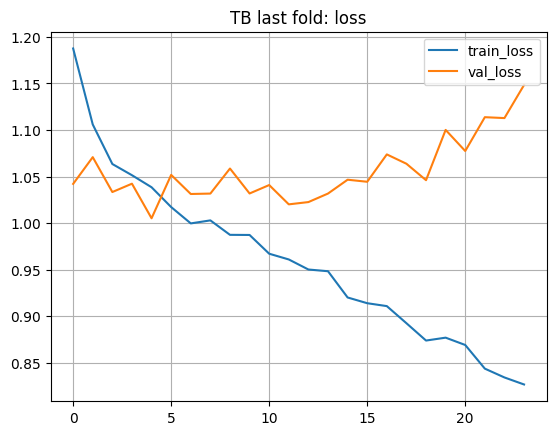

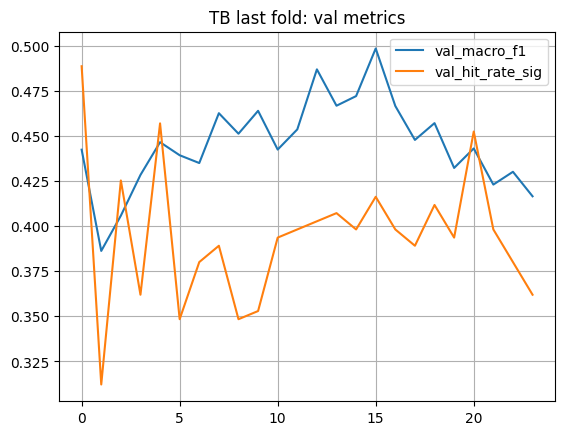

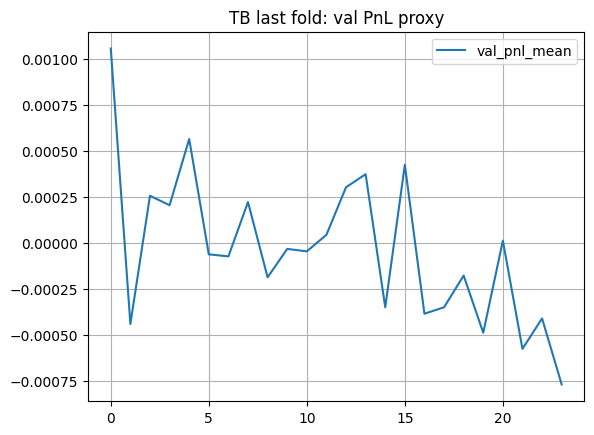

In [64]:
# ЛОГИЧЕСКИЙ БЛОК: visualize last TB fold
# ИСПОЛНЕНИЕ БЛОКА:

last_hist = fold_results_tb[-1]["hist"]

import matplotlib.pyplot as plt

plt.figure()
plt.plot(last_hist["tr_loss"], label="train_loss")
plt.plot(last_hist["va_loss"], label="val_loss")
plt.title("TB last fold: loss")
plt.legend(); plt.grid(True); plt.show()

plt.figure()
plt.plot(last_hist["va_f1m"], label="val_macro_f1")
plt.plot(last_hist["va_hit_sig"], label="val_hit_rate_sig")
plt.title("TB last fold: val metrics")
plt.legend(); plt.grid(True); plt.show()

plt.figure()
plt.plot(last_hist["va_pnl_mean"], label="val_pnl_mean")
plt.title("TB last fold: val PnL proxy")
plt.legend(); plt.grid(True); plt.show()
